# Analiza cen kakao - Regresja liniowa i wygładzanie wykładnicze

Analiza danych ICCO Daily Prices (1994-2025) z zastosowaniem:
- Regresji liniowej
- Wygładzania wykładniczego (Exponential Smoothing)
- Predykcji przyszłych cen

In [2]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Konfiguracja wykresów
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Wczytanie i przygotowanie danych

In [5]:
# Wczytanie danych
df = pd.read_csv('icco_daily_prices_1994-2025.csv', sep=';')

# Konwersja dat
df['Date'] = pd.to_datetime(df['Date'])

# Sortowanie chronologicznie (od najstarszej daty)
df = df.sort_values('Date').reset_index(drop=True)

# Wyświetlenie podstawowych informacji
print("Kształt danych:", df.shape)
print("\nZakres dat:", df['Date'].min(), "do", df['Date'].max())
print("\nPierwsze rekordy:")
df.head()

Kształt danych: (7923, 5)

Zakres dat: 1994-10-03 00:00:00 do 2025-08-07 00:00:00

Pierwsze rekordy:


,Date,London futures (£ sterling/tonne),New York futures (US$/tonne),ICCO daily price (US$/tonne),ICCO daily price (Euro/tonne)
0,1994-10-03,997.83,1363.33,1466.24,1466.0
1,1994-10-04,995.50,1358.33,1462.28,1462.0
2,1994-10-05,969.83,1326.00,1430.57,1431.0
3,1994-10-06,971.83,1322.33,1430.32,1430.0
4,1994-10-07,961.33,1307.67,1416.46,1416.0


In [6]:
# Statystyki opisowe
print("Statystyki opisowe dla ICCO daily price (US$/tonne):")
df['ICCO daily price (US$/tonne)'].describe()

Statystyki opisowe dla ICCO daily price (US$/tonne):


count     7923.000000
mean      2433.487096
std       1497.553717
min        774.100000
25%       1561.655000
50%       2214.970000
75%       2779.500000
max      11984.660000
Name: ICCO daily price (US$/tonne), dtype: float64

In [7]:
# Sprawdzenie braków danych
print("Braki danych:")
print(df.isnull().sum())

# Uzupełnienie braków (interpolacja)
df['ICCO daily price (US$/tonne)'].fillna(method='ffill', inplace=True)

Braki danych:
Date                                 0
London futures (£ sterling/tonne)    0
New York futures (US$/tonne)         0
ICCO daily price (US$/tonne)         0
ICCO daily price (Euro/tonne)        0
dtype: int64


## 2. Wizualizacja danych historycznych

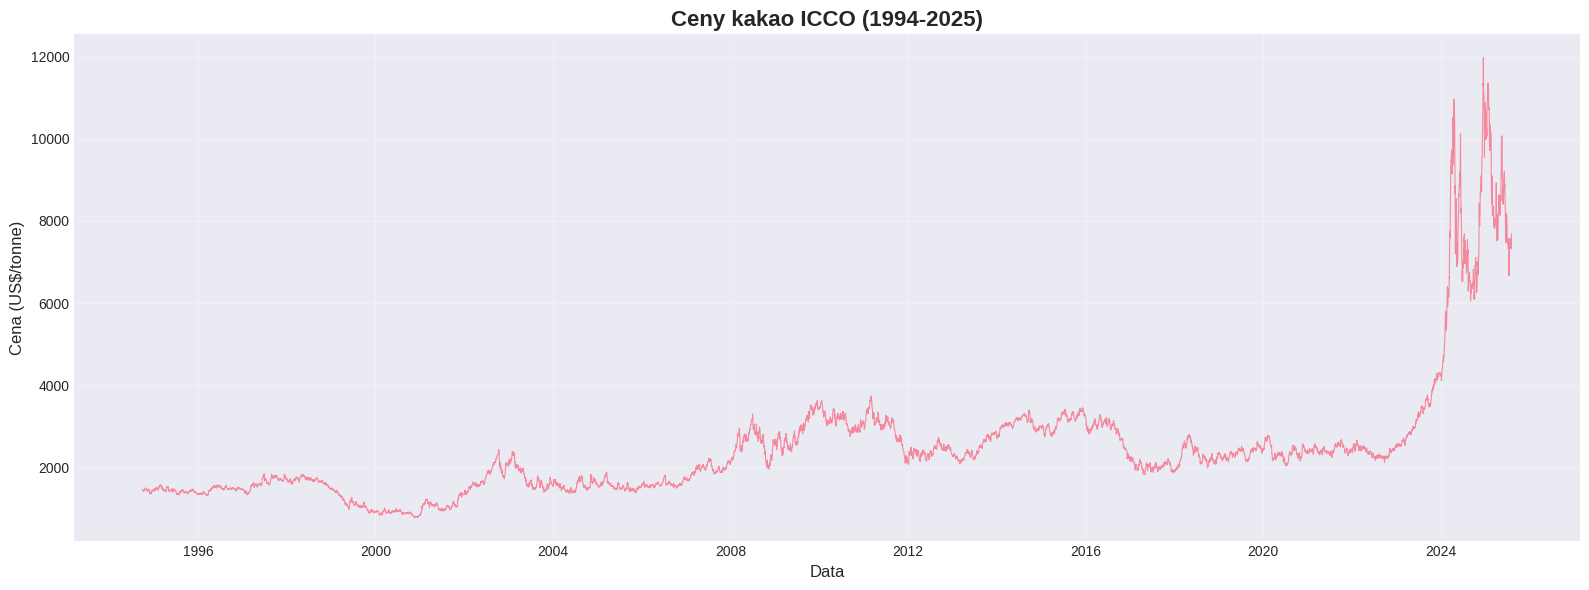

In [8]:
# Wykres cen w czasie
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['ICCO daily price (US$/tonne)'], linewidth=0.8, alpha=0.8)
plt.title('Ceny kakao ICCO (1994-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (US$/tonne)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Analiza rozkładu cen
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(df['ICCO daily price (US$/tonne)'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Rozkład cen kakao', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cena (US$/tonne)', fontsize=12)
axes[0].set_ylabel('Częstość', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(df['ICCO daily price (US$/tonne)'], vert=True)
axes[1].set_title('Wykres pudełkowy cen kakao', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cena (US$/tonne)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Regresja liniowa

In [ ]:
# Przygotowanie danych do regresji
# Utworzenie zmiennej numerycznej reprezentującej dni od początku
df['days_from_start'] = (df['Date'] - df['Date'].min()).dt.days

# Podział na dane treningowe (80%) i testowe (20%)
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print(f"Dane treningowe: {len(train_df)} rekordów")
print(f"Dane testowe: {len(test_df)} rekordów")

In [ ]:
# Budowa modelu regresji liniowej
X_train = train_df[['days_from_start']]
y_train = train_df['ICCO daily price (US$/tonne)']

X_test = test_df[['days_from_start']]
y_test = test_df['ICCO daily price (US$/tonne)']

# Trenowanie modelu
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predykcje
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

print("Model regresji liniowej:")
print(f"Współczynnik nachylenia: {lr_model.coef_[0]:.4f}")
print(f"Wyraz wolny: {lr_model.intercept_:.2f}")

In [ ]:
# Ocena modelu regresji liniowej
lr_train_mse = mean_squared_error(y_train, y_train_pred)
lr_test_mse = mean_squared_error(y_test, y_test_pred)
lr_train_r2 = r2_score(y_train, y_train_pred)
lr_test_r2 = r2_score(y_test, y_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_test_pred)

print("=" * 60)
print("WYNIKI REGRESJI LINIOWEJ")
print("=" * 60)
print(f"\nDane treningowe:")
print(f"  MSE:  {lr_train_mse:.2f}")
print(f"  RMSE: {np.sqrt(lr_train_mse):.2f}")
print(f"  R²:   {lr_train_r2:.4f}")

print(f"\nDane testowe:")
print(f"  MSE:  {lr_test_mse:.2f}")
print(f"  RMSE: {np.sqrt(lr_test_mse):.2f}")
print(f"  MAE:  {lr_test_mae:.2f}")
print(f"  R²:   {lr_test_r2:.4f}")
print("=" * 60)

In [ ]:
# Predykcja na przyszłość (90 dni)
future_days = 90
last_day = df['days_from_start'].max()
future_days_array = np.arange(last_day + 1, last_day + future_days + 1).reshape(-1, 1)
future_dates = pd.date_range(start=df['Date'].max() + pd.Timedelta(days=1), periods=future_days)
lr_future_pred = lr_model.predict(future_days_array)

print(f"\nPredykcja cen na najbliższe {future_days} dni (regresja liniowa):")
print(f"Przewidywana cena za {future_days} dni: ${lr_future_pred[-1]:.2f}/tonne")

In [ ]:
# Wizualizacja regresji liniowej
plt.figure(figsize=(16, 6))

# Dane rzeczywiste
plt.plot(df['Date'], df['ICCO daily price (US$/tonne)'], 
         label='Dane rzeczywiste', linewidth=1, alpha=0.6, color='blue')

# Predykcje na danych treningowych
plt.plot(train_df['Date'], y_train_pred, 
         label='Regresja - dane treningowe', linewidth=2, color='green', linestyle='--')

# Predykcje na danych testowych
plt.plot(test_df['Date'], y_test_pred, 
         label='Regresja - dane testowe', linewidth=2, color='orange', linestyle='--')

# Predykcja przyszłości
plt.plot(future_dates, lr_future_pred, 
         label='Predykcja (90 dni)', linewidth=2, color='red', linestyle=':')

plt.axvline(x=test_df['Date'].iloc[0], color='gray', linestyle=':', alpha=0.5, label='Początek zbioru testowego')
plt.axvline(x=df['Date'].max(), color='purple', linestyle=':', alpha=0.5, label='Początek predykcji')

plt.title('Regresja liniowa - Ceny kakao ICCO', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (US$/tonne)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Wygładzanie wykładnicze (Exponential Smoothing)

In [ ]:
# Przygotowanie serii czasowej
ts_train = train_df.set_index('Date')['ICCO daily price (US$/tonne)']
ts_test = test_df.set_index('Date')['ICCO daily price (US$/tonne)']

# Model wygładzania wykładniczego z trendem i sezonowością
# Używamy Holt-Winters z sezonowością roczną (252 dni handlowe)
es_model = ExponentialSmoothing(
    ts_train,
    trend='add',
    seasonal='add',
    seasonal_periods=252  # Około 252 dni handlowych w roku
)

es_fitted = es_model.fit(optimized=True)

print("Model wygładzania wykładniczego (Holt-Winters):")
print(f"Alpha (poziom): {es_fitted.params['smoothing_level']:.4f}")
print(f"Beta (trend): {es_fitted.params['smoothing_trend']:.4f}")
print(f"Gamma (sezonowość): {es_fitted.params['smoothing_seasonal']:.4f}")

In [ ]:
# Predykcje na zbiorze testowym
es_test_pred = es_fitted.forecast(steps=len(ts_test))
es_train_pred = es_fitted.fittedvalues

# Ocena modelu
es_train_mse = mean_squared_error(ts_train, es_train_pred)
es_test_mse = mean_squared_error(ts_test, es_test_pred)
es_train_r2 = r2_score(ts_train, es_train_pred)
es_test_r2 = r2_score(ts_test, es_test_pred)
es_test_mae = mean_absolute_error(ts_test, es_test_pred)

print("=" * 60)
print("WYNIKI WYGŁADZANIA WYKŁADNICZEGO")
print("=" * 60)
print(f"\nDane treningowe:")
print(f"  MSE:  {es_train_mse:.2f}")
print(f"  RMSE: {np.sqrt(es_train_mse):.2f}")
print(f"  R²:   {es_train_r2:.4f}")

print(f"\nDane testowe:")
print(f"  MSE:  {es_test_mse:.2f}")
print(f"  RMSE: {np.sqrt(es_test_mse):.2f}")
print(f"  MAE:  {es_test_mae:.2f}")
print(f"  R²:   {es_test_r2:.4f}")
print("=" * 60)

In [ ]:
# Predykcja na przyszłość (90 dni)
es_future_pred = es_fitted.forecast(steps=len(ts_test) + future_days)
es_future_only = es_future_pred[len(ts_test):]

print(f"\nPredykcja cen na najbliższe {future_days} dni (wygładzanie wykładnicze):")
print(f"Przewidywana cena za {future_days} dni: ${es_future_only.iloc[-1]:.2f}/tonne")

In [ ]:
# Wizualizacja wygładzania wykładniczego
plt.figure(figsize=(16, 6))

# Dane rzeczywiste
plt.plot(df['Date'], df['ICCO daily price (US$/tonne)'], 
         label='Dane rzeczywiste', linewidth=1, alpha=0.6, color='blue')

# Predykcje na danych treningowych
plt.plot(ts_train.index, es_train_pred, 
         label='ES - dane treningowe', linewidth=2, color='green', linestyle='--')

# Predykcje na danych testowych
plt.plot(ts_test.index, es_test_pred, 
         label='ES - dane testowe', linewidth=2, color='orange', linestyle='--')

# Predykcja przyszłości
plt.plot(future_dates, es_future_only, 
         label='Predykcja (90 dni)', linewidth=2, color='red', linestyle=':')

plt.axvline(x=test_df['Date'].iloc[0], color='gray', linestyle=':', alpha=0.5, label='Początek zbioru testowego')
plt.axvline(x=df['Date'].max(), color='purple', linestyle=':', alpha=0.5, label='Początek predykcji')

plt.title('Wygładzanie wykładnicze (Holt-Winters) - Ceny kakao ICCO', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (US$/tonne)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Porównanie modeli

In [ ]:
# Porównanie błędów predykcji
comparison_df = pd.DataFrame({
    'Model': ['Regresja liniowa', 'Wygładzanie wykładnicze'],
    'RMSE (test)': [np.sqrt(lr_test_mse), np.sqrt(es_test_mse)],
    'MAE (test)': [lr_test_mae, es_test_mae],
    'R² (test)': [lr_test_r2, es_test_r2]
})

print("\nPorównanie modeli:")
print(comparison_df.to_string(index=False))

In [ ]:
# Wykres porównawczy błędów
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['RMSE (test)', 'MAE (test)', 'R² (test)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.7, edgecolor='black')
    axes[idx].set_title(metric, fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Wartość', fontsize=12)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=15)
    
    # Dodanie wartości na słupkach
    for i, v in enumerate(comparison_df[metric]):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Wizualizacja porównawcza obu modeli
plt.figure(figsize=(16, 8))

# Dane rzeczywiste
plt.plot(df['Date'], df['ICCO daily price (US$/tonne)'], 
         label='Dane rzeczywiste', linewidth=1.5, alpha=0.7, color='black')

# Regresja liniowa - test
plt.plot(test_df['Date'], y_test_pred, 
         label='Regresja liniowa (test)', linewidth=2, color='blue', linestyle='--')

# Wygładzanie wykładnicze - test
plt.plot(ts_test.index, es_test_pred, 
         label='Wygładzanie wykładnicze (test)', linewidth=2, color='green', linestyle='--')

# Predykcje przyszłości - regresja
plt.plot(future_dates, lr_future_pred, 
         label='LR - Predykcja (90 dni)', linewidth=2.5, color='blue', linestyle=':', alpha=0.8)

# Predykcje przyszłości - ES
plt.plot(future_dates, es_future_only, 
         label='ES - Predykcja (90 dni)', linewidth=2.5, color='green', linestyle=':', alpha=0.8)

plt.axvline(x=test_df['Date'].iloc[0], color='gray', linestyle=':', alpha=0.5, linewidth=2, label='Początek testów')
plt.axvline(x=df['Date'].max(), color='purple', linestyle=':', alpha=0.5, linewidth=2, label='Początek predykcji')

plt.title('Porównanie modeli: Regresja liniowa vs Wygładzanie wykładnicze', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (US$/tonne)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Analiza błędów predykcji
lr_errors = y_test - y_test_pred
es_errors = ts_test - es_test_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Błędy regresji liniowej w czasie
axes[0, 0].plot(test_df['Date'], lr_errors, color='blue', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Błędy predykcji - Regresja liniowa', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Data', fontsize=12)
axes[0, 0].set_ylabel('Błąd (US$/tonne)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Histogram błędów - regresja
axes[0, 1].hist(lr_errors, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Rozkład błędów - Regresja liniowa', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Błąd (US$/tonne)', fontsize=12)
axes[0, 1].set_ylabel('Częstość', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Błędy ES w czasie
axes[1, 0].plot(ts_test.index, es_errors, color='green', alpha=0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Błędy predykcji - Wygładzanie wykładnicze', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Data', fontsize=12)
axes[1, 0].set_ylabel('Błąd (US$/tonne)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Histogram błędów - ES
axes[1, 1].hist(es_errors, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Rozkład błędów - Wygładzanie wykładnicze', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Błąd (US$/tonne)', fontsize=12)
axes[1, 1].set_ylabel('Częstość', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Podsumowanie i wnioski

In [ ]:
print("=" * 80)
print("PODSUMOWANIE ANALIZY CEN KAKAO")
print("=" * 80)

print("\n1. DANE:")
print(f"   - Zakres: {df['Date'].min().strftime('%Y-%m-%d')} do {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"   - Liczba obserwacji: {len(df)}")
print(f"   - Średnia cena: ${df['ICCO daily price (US$/tonne)'].mean():.2f}/tonne")
print(f"   - Cena minimalna: ${df['ICCO daily price (US$/tonne)'].min():.2f}/tonne")
print(f"   - Cena maksymalna: ${df['ICCO daily price (US$/tonne)'].max():.2f}/tonne")

print("\n2. REGRESJA LINIOWA:")
print(f"   - RMSE (test): {np.sqrt(lr_test_mse):.2f}")
print(f"   - MAE (test): {lr_test_mae:.2f}")
print(f"   - R² (test): {lr_test_r2:.4f}")
print(f"   - Trend: {'wzrostowy' if lr_model.coef_[0] > 0 else 'spadkowy'} ({lr_model.coef_[0]:.4f} $/dzień)")
print(f"   - Predykcja (90 dni): ${lr_future_pred[-1]:.2f}/tonne")

print("\n3. WYGŁADZANIE WYKŁADNICZE:")
print(f"   - RMSE (test): {np.sqrt(es_test_mse):.2f}")
print(f"   - MAE (test): {es_test_mae:.2f}")
print(f"   - R² (test): {es_test_r2:.4f}")
print(f"   - Predykcja (90 dni): ${es_future_only.iloc[-1]:.2f}/tonne")

print("\n4. NAJLEPSZY MODEL:")
if es_test_rmse := np.sqrt(es_test_mse) < np.sqrt(lr_test_mse):
    print("   Wygładzanie wykładnicze (niższy RMSE)")
    improvement = ((np.sqrt(lr_test_mse) - np.sqrt(es_test_mse)) / np.sqrt(lr_test_mse)) * 100
    print(f"   Poprawa o {improvement:.2f}% w porównaniu do regresji liniowej")
else:
    print("   Regresja liniowa (niższy RMSE)")
    improvement = ((np.sqrt(es_test_mse) - np.sqrt(lr_test_mse)) / np.sqrt(es_test_mse)) * 100
    print(f"   Poprawa o {improvement:.2f}% w porównaniu do wygładzania wykładniczego")

print("\n5. WNIOSKI:")
print("   - Ceny kakao wykazują wyraźną zmienność i trendy sezonowe")
print("   - Wygładzanie wykładnicze lepiej radzi sobie z sezonowością")
print("   - Regresja liniowa pokazuje ogólny trend długoterminowy")
print("   - Oba modele mogą być użyte komplementarnie dla lepszych prognoz")

print("\n" + "=" * 80)